In [1]:
from __future__ import print_function
import cProfile
import pandas as pd
import tables as tb
import numpy as np
from Util import *
import time
import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as snf
import tblFunctions as tbl
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2
print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

/Applications/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


This notebook has been run last on 20/10/2016 at 18:50:24.


In [ ]:
# %load /Users/Gonzalo/github/IC/Config/DIOMIRA_default.csv
#Configuration file for DIOMIRA
PATH_IN,PATH_OUT,FILE_IN,FILE_OUT,PATH_DB,FIRST_EVT,LAST_EVT,BLR,NOISE_CUT,RUN_ALL,CLIB,CLEVEL
/Users/Gonzalo/github/IC/data/,/Users/Gonzalo/github/IC/data/,in0.h5,DIOMIRA500.h5,/Users/Gonzalo/github/IC/Database/,0,500,1,0.9,1,zlib,1


# DIOMIRA

In [7]:
try:
    h5f.close()
except:
    pass

In [8]:
h5f = tb.open_file('/Users/Gonzalo/github/IC/data/DIOMIRA500_bkup.h5')
print(h5f)

/Users/Gonzalo/github/IC/data/DIOMIRA500.h5 (File) ''
Last modif.: 'Thu Oct 20 19:05:03 2016'
Object Tree: 
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(4144,), zlib(1)) ''
/RD (Group) ''
/RD/pmtblr (EArray(500, 12, 32000), shuffle, zlib(1)) ''
/RD/pmtrwf (EArray(500, 12, 32000), shuffle, zlib(1)) ''
/RD/sipmrwf (EArray(500, 1789, 800), shuffle, zlib(1)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1789,)) ''
/TWF (Group) ''
/TWF/PMT (Table(7008,), shuffle, zlib(1)) 'Store for PMTs TWF'
/TWF/SiPM (Table(44112,), shuffle, zlib(1)) 'Store for SiPM TWF'



In [32]:
fee_tabl = h5f.root.MC.FEE

pmttwf   = h5f.root.TWF.PMT
sipmtwf  = h5f.root.TWF.SiPM

pmtblr   = h5f.root.RD.pmtblr
pmtrwf   = h5f.root.RD.pmtrwf
sipmrwf  = h5f.root.RD.sipmrwf

pmtdf    = snf.read_data_sensors(h5f.root.Sensors.DataPMT)
blrdf    = snf.read_data_sensors(h5f.root.Sensors.DataBLR)
sipmdf   = snf.read_data_sensors(h5f.root.Sensors.DataSiPM)

### PMT DF:

In [29]:
print(pmtdf)

    adc_to_pes  channel     coeff  noise_rms           x           y
0   -22.916800        0  0.001641    9.69957  -23.941401   65.778503
1   -23.750999        1  0.001623   10.73670  -44.995098  -53.623100
2   -25.300800        2  0.000000    9.27125   68.936501  -12.155400
3   -25.998400        3  0.000000    9.88896   -0.000000  185.000000
4   -23.707399        4  0.001596    8.32661 -118.916000  141.718002
5   -20.892700        5  0.001581    7.03380 -182.188995   32.124901
6   -22.134001        6  0.000000    7.85048 -160.214996  -92.500000
7   -33.099300        7  0.000000   12.01220  -63.273701 -173.843002
8   -20.437700        8  0.001622    7.18150   63.273701 -173.843002
9   -25.169800        9  0.001601    8.72723  160.214996  -92.500000
10  -15.855700       10  0.000000    7.20675  182.188995   32.124901
11  -18.212999       11  0.000000    8.16961  118.916000  141.718002


### BLR DF:

In [30]:
print(blrdf)

    adc_to_pes  channel     coeff  noise_rms           x           y
0   -22.916800        0  0.001641    9.69957  -23.941401   65.778503
1   -23.750999        1  0.001623   10.73670  -44.995098  -53.623100
2   -25.300800        2  0.000000    9.27125   68.936501  -12.155400
3   -25.998400        3  0.000000    9.88896   -0.000000  185.000000
4   -23.707399        4  0.001596    8.32661 -118.916000  141.718002
5   -20.892700        5  0.001581    7.03380 -182.188995   32.124901
6   -22.134001        6  0.000000    7.85048 -160.214996  -92.500000
7   -33.099300        7  0.000000   12.01220  -63.273701 -173.843002
8   -20.437700        8  0.001622    7.18150   63.273701 -173.843002
9   -25.169800        9  0.001601    8.72723  160.214996  -92.500000
10  -15.855700       10  0.000000    7.20675  182.188995   32.124901
11  -18.212999       11  0.000000    8.16961  118.916000  141.718002


### FEE table:

In [57]:
for i in fee_tabl.colnames: print(i, '->', fee_tabl.col(i)[0])

offset -> 2500
ceiling -> 4096
pmt_gain -> 4.5e+06
V_gain -> 4.00544e-14
R -> 3.76512e-13
time_step -> 1.0
time_daq -> 25.0
freq_LPF -> 0.003
freq_HPF -> 1.09235e-05
LSB -> 4.88281e-10
volts_to_adc -> 0.000390625
noise_fee_rms -> 3e-10
noise_adc -> 0.768
C12 -> [  3.76347497e+16   3.88563243e+16   3.78680523e+16   3.88321222e+16
   3.93214779e+16   3.80664712e+16   3.85905732e+16   3.88081648e+16
   3.86540657e+16   3.93538705e+16   3.87198002e+16   3.93983363e+16]
AC -> [ 0.00165235  0.00163149  0.00163177  0.00162948  0.00158202  0.00159469
  0.00162493  0.00164257  0.00162681  0.00162087  0.00160063  0.00161127]
CR -> [ 19.30316353  19.16122627  19.39785004  19.2327404   19.06361771
  18.49583435  19.41022301  18.61515808  19.08126831  19.13311577
  18.56428719  19.60046768]
CB -> [ 19.73992348  19.58441734  19.83195114  19.65619278  19.48186111
  18.92770004  19.83629227  19.03886795  19.50664711  19.55101776
  18.98895264  20.01790428]


### Plot of the PMT TWF, RWF, BLR for event 0, PMT 0

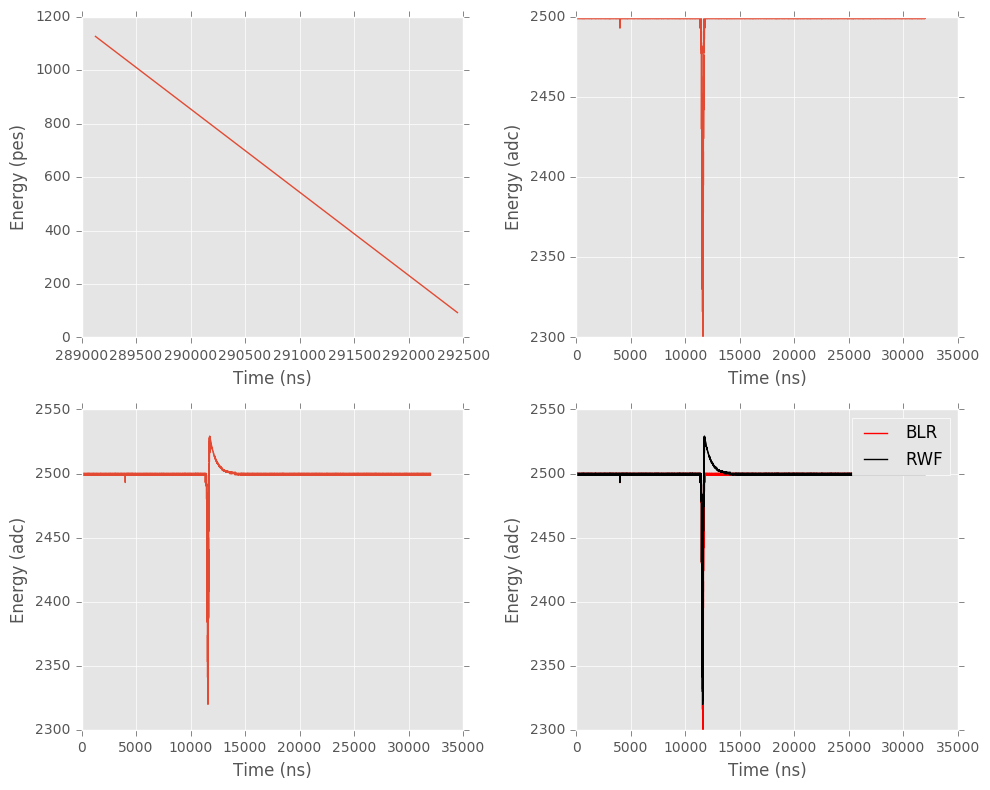

In [22]:
Tt, Te = tbl.read_wf(pmttwf,0,0)

fig, axes = plt.subplots(2,2)
axes[0,0].plot(Tt,Te)
axes[0,1].plot(pmtblr[0,0])
axes[1,0].plot(pmtrwf[0,0])
axes[1,1].plot(pmtblr[0,0],'r',label='BLR')
axes[1,1].plot(pmtrwf[0,0],'k',label='RWF')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylabel('Energy (pes)');axes[0,0].set_title('True waveform')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylabel('Energy (adc)');axes[0,1].set_title('BLR waveform')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylabel('Energy (adc)');axes[1,0].set_title('Raw waveform')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylabel('Energy (adc)');axes[1,1].set_title('Comparison')

axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

# ISIDORA

In [59]:
try:
    h5f.close()
except:
    pass

In [60]:
h5f = tb.open_file('/Users/Gonzalo/github/IC/data/ISIDORA500_bkup.h5')
print(h5f)

/Users/Gonzalo/github/IC/data/ISIDORA500.h5 (File) ''
Last modif.: 'Fri Oct 21 00:05:36 2016'
Object Tree: 
/ (RootGroup) ''
/BLR (Group) ''
/BLR/mau (EArray(500, 32000), shuffle, zlib(1)) ''
/BLR/pulse_on (EArray(500, 32000), shuffle, zlib(1)) ''
/BLR/wait_over (EArray(500, 32000), shuffle, zlib(1)) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(4144,), zlib(1)) ''
/RD (Group) ''
/RD/pmtblr (EArray(500, 12, 32000), shuffle, zlib(1)) ''
/RD/pmtcwf (EArray(500, 12, 32000), shuffle, zlib(1)) ''
/RD/pmtrwf (EArray(500, 12, 32000), shuffle, zlib(1)) ''
/RD/sipmrwf (EArray(500, 1789, 800), shuffle, zlib(1)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1789,)) ''
/TWF (Group) ''
/TWF/PMT (Table(7008,), shuffle, zlib(1)) 'Store for PMTs TWF'
/TWF/SiPM (Table(44112,), shuffle, zlib(1)) 'Store for SiPM TWF'



In [62]:
fee_tabl = h5f.root.MC.FEE

pmttwf   = h5f.root.TWF.PMT
sipmtwf  = h5f.root.TWF.SiPM

blrmau   = h5f.root.BLR.mau
blrpulse = h5f.root.BLR.pulse_on
blrwait  = h5f.root.BLR.wait_over

pmtcwf   = h5f.root.RD.pmtcwf
pmtblr   = h5f.root.RD.pmtblr
pmtrwf   = h5f.root.RD.pmtrwf
sipmrwf  = h5f.root.RD.sipmrwf

pmtdf    = snf.read_data_sensors(h5f.root.Sensors.DataPMT)
blrdf    = snf.read_data_sensors(h5f.root.Sensors.DataBLR)
sipmdf   = snf.read_data_sensors(h5f.root.Sensors.DataSiPM)

### Plot of the RWF, BLR and CWF for event 0 PMT 0:

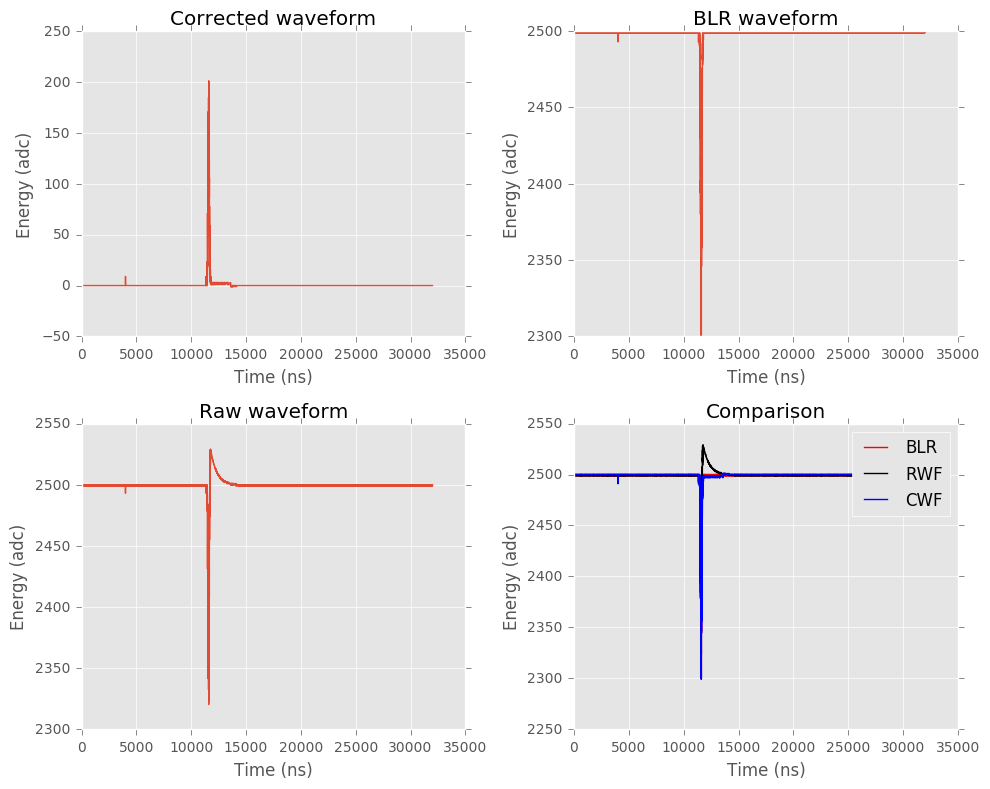

In [64]:
fig, axes = plt.subplots(2,2)
axes[0,0].plot(pmtcwf[0,0])
axes[0,1].plot(pmtblr[0,0])
axes[1,0].plot(pmtrwf[0,0])
axes[1,1].plot(pmtblr[0,0],'r',label='BLR')
axes[1,1].plot(pmtrwf[0,0],'k',label='RWF')
axes[1,1].plot(2500-pmtcwf[0,0],'b',label='CWF')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylabel('Energy (adc)');axes[0,0].set_title('Corrected waveform')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylabel('Energy (adc)');axes[0,1].set_title('BLR waveform')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylabel('Energy (adc)');axes[1,0].set_title('Raw waveform')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylabel('Energy (adc)');axes[1,1].set_title('Comparison')

axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

### Plot of the mau, pulse_on and wait_over variables for event 0

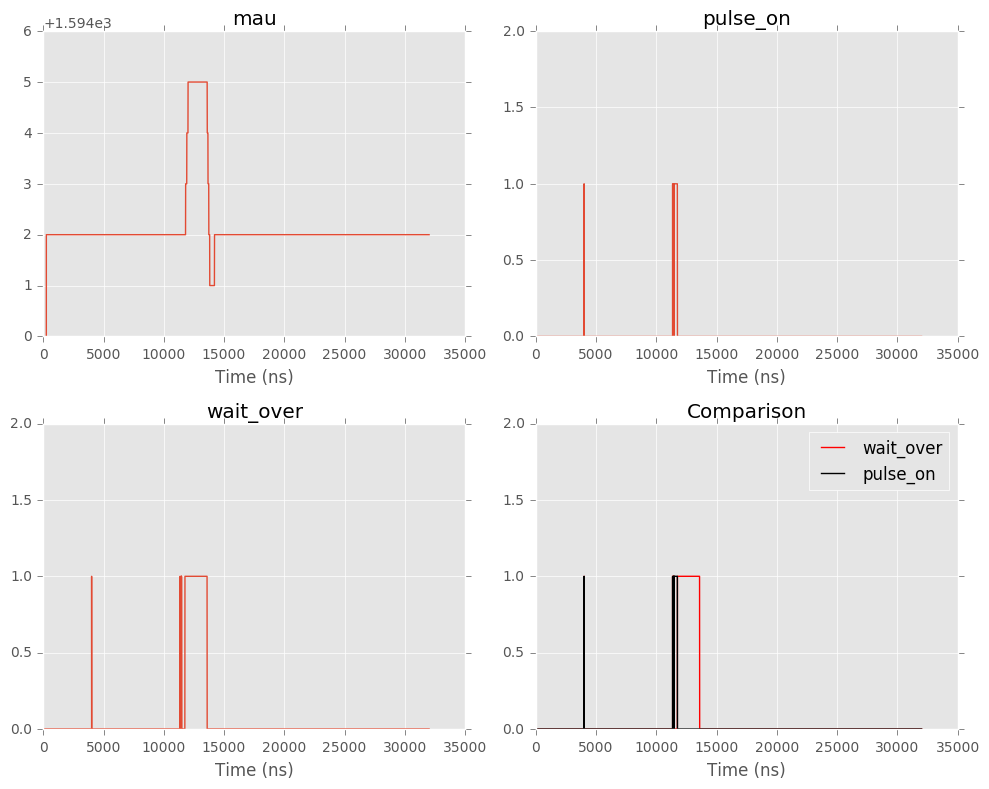

In [99]:
fig, axes = plt.subplots(2,2)
axes[0,0].plot(blrmau[0])
axes[0,1].plot(blrpulse[0])
axes[1,0].plot(blrwait[0])
axes[1,1].plot(blrwait[0],'r',label='wait_over')
axes[1,1].plot(blrpulse[0],'k',label='pulse_on')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylim((1594,1600));axes[0,0].set_title('mau')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylim((0,2));axes[0,1].set_title('pulse_on')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylim((0,2));axes[1,0].set_title('wait_over')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylim((0,2));axes[1,1].set_title('Comparison')

axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

# ANASTASIA

In [100]:
try:
    h5f.close()
except:
    pass

In [101]:
h5f = tb.open_file('/Users/Gonzalo/github/IC/data/ANASTASIA500_bkup.h5')
print(h5f)

/Users/Gonzalo/github/IC/data/ANASTASIA500_bkup.h5 (File) ''
Last modif.: 'Fri Oct 21 10:25:46 2016'
Object Tree: 
/ (RootGroup) ''
/BLR (Group) ''
/BLR/mau (EArray(500, 32000), shuffle, zlib(1)) ''
/BLR/pulse_on (EArray(500, 32000), shuffle, zlib(1)) ''
/BLR/wait_over (EArray(500, 32000), shuffle, zlib(1)) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(4144,), zlib(1)) ''
/RD (Group) ''
/RD/pmtblr (EArray(500, 12, 32000), shuffle, zlib(1)) ''
/RD/pmtcwf (EArray(500, 12, 32000), shuffle, zlib(1)) ''
/RD/pmtrwf (EArray(500, 12, 32000), shuffle, zlib(1)) ''
/RD/sipmrwf (EArray(500, 1789, 800), shuffle, zlib(1)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1789,)) ''
/TWF (Group) ''
/TWF/PMT (Table(7008,), shuffle, zlib(1)) 'Store for PMTs TWF'
/TWF/SiPM (Table(44112,), shuffle, zlib(1)) 'Store for SiPM TWF'
/ZS (Group) ''
/ZS/B

In [102]:
fee_tabl = h5f.root.MC.FEE

pmttwf   = h5f.root.TWF.PMT
sipmtwf  = h5f.root.TWF.SiPM

blrmau   = h5f.root.BLR.mau
blrpulse = h5f.root.BLR.pulse_on
blrwait  = h5f.root.BLR.wait_over

pmtcwf   = h5f.root.RD.pmtcwf
pmtblr   = h5f.root.RD.pmtblr
pmtrwf   = h5f.root.RD.pmtrwf
sipmrwf  = h5f.root.RD.sipmrwf

pmtzswf  = h5f.root.ZS.PMT
blrzswf  = h5f.root.ZS.BLR
sipmzswf = h5f.root.ZS.SiPM

pmtdf    = snf.read_data_sensors(h5f.root.Sensors.DataPMT)
blrdf    = snf.read_data_sensors(h5f.root.Sensors.DataBLR)
sipmdf   = snf.read_data_sensors(h5f.root.Sensors.DataSiPM)

### Plot of the ZS CWF, and BLR for event 0 (PMT-summed):

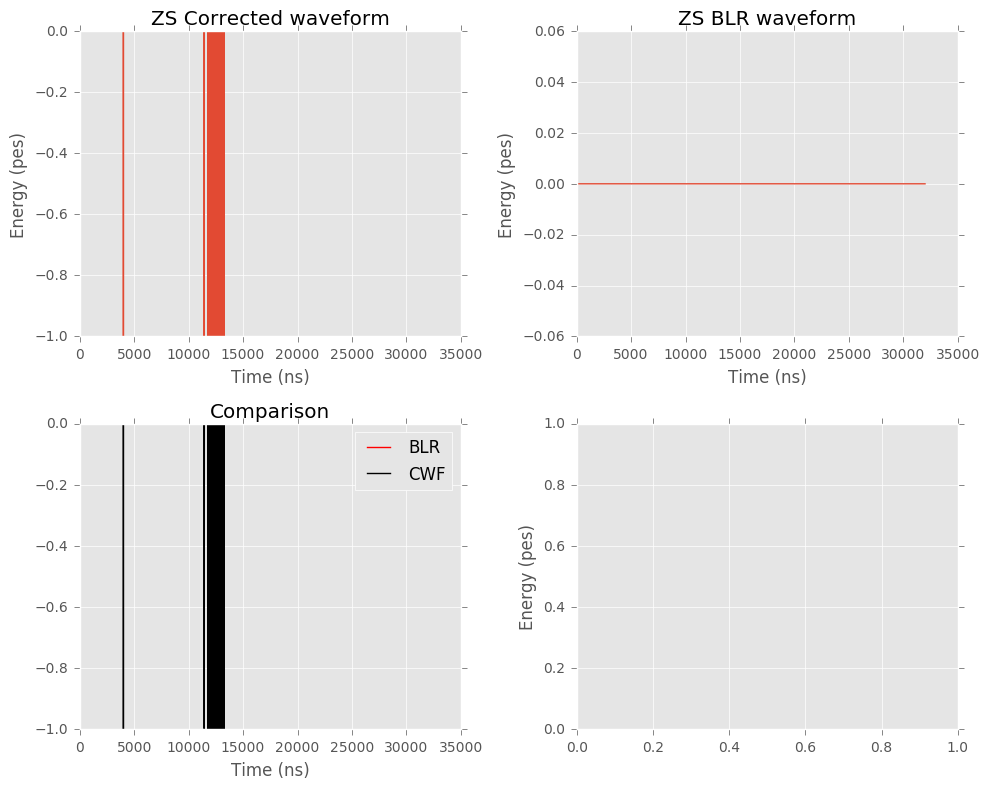

In [117]:
fig, axes = plt.subplots(2,2)

axes[0,0].plot(pmtzswf[0,0])
axes[0,1].plot(blrzswf[0,0])
axes[1,0].plot(blrzswf[0,0],'r',label='BLR')
axes[1,0].plot(pmtzswf[0,0],'k',label='CWF')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylabel('Energy (pes)');axes[0,0].set_title('ZS Corrected waveform')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylabel('Energy (pes)');axes[0,1].set_title('ZS BLR waveform')
axes[1,0].set_xlabel('Time (ns)');axes[1,1].set_ylabel('Energy (pes)');axes[1,0].set_title('Comparison')

axes[1,0].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

In [118]:
pmtdf

,adc_to_pes,channel,coeff,noise_rms,x,y
0,-22.916800,0,0.001641,9.69957,-23.941401,65.778503
1,-23.750999,1,0.001623,10.73670,-44.995098,-53.623100
2,-25.300800,2,0.000000,9.27125,68.936501,-12.155400
3,-25.998400,3,0.000000,9.88896,-0.000000,185.000000
4,-23.707399,4,0.001596,8.32661,-118.916000,141.718002
5,-20.892700,5,0.001581,7.03380,-182.188995,32.124901
6,-22.134001,6,0.000000,7.85048,-160.214996,-92.500000
7,-33.099300,7,0.000000,12.01220,-63.273701,-173.843002
8,-20.437700,8,0.001622,7.18150,63.273701,-173.843002
9,-25.169800,9,0.001601,8.72723,160.214996,-92.500000


### Plot of the mau, pulse_on and wait_over variables for event 0

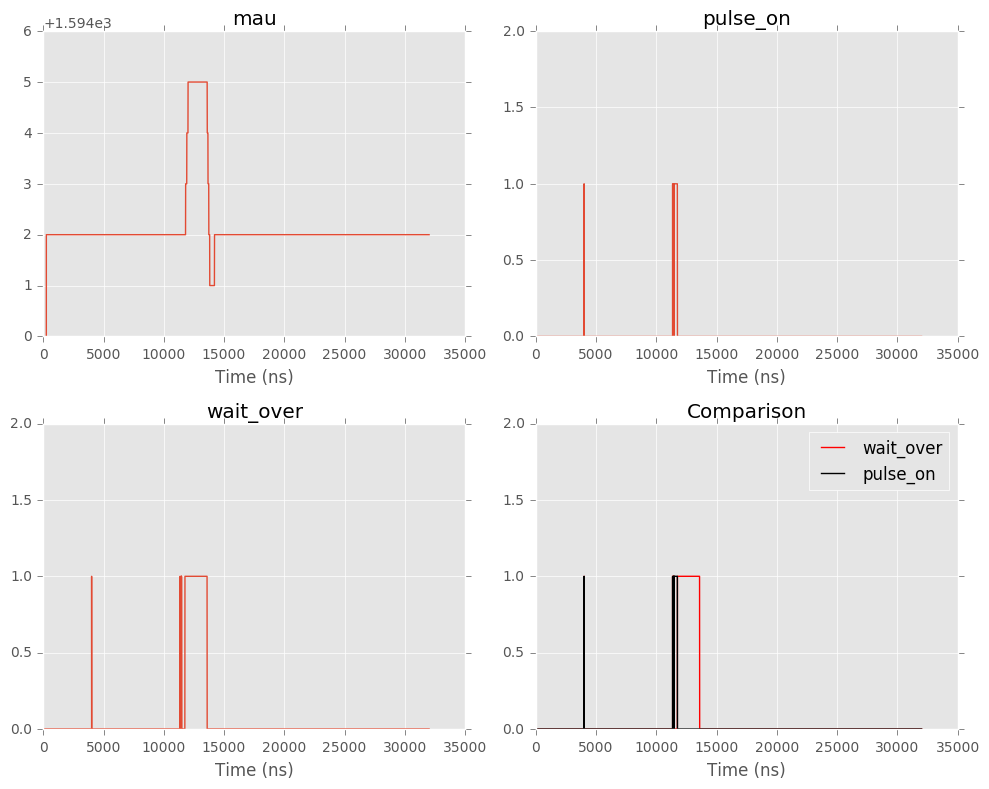

In [99]:
fig, axes = plt.subplots(2,2)
axes[0,0].plot(blrmau[0])
axes[0,1].plot(blrpulse[0])
axes[1,0].plot(blrwait[0])
axes[1,1].plot(blrwait[0],'r',label='wait_over')
axes[1,1].plot(blrpulse[0],'k',label='pulse_on')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylim((1594,1600));axes[0,0].set_title('mau')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylim((0,2));axes[0,1].set_title('pulse_on')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylim((0,2));axes[1,0].set_title('wait_over')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylim((0,2));axes[1,1].set_title('Comparison')

axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

In [ ]:

#
#pmtzswf  = h5f.root.ZS.PMT
#sipmzswf = h5f.root.ZS.SiPM



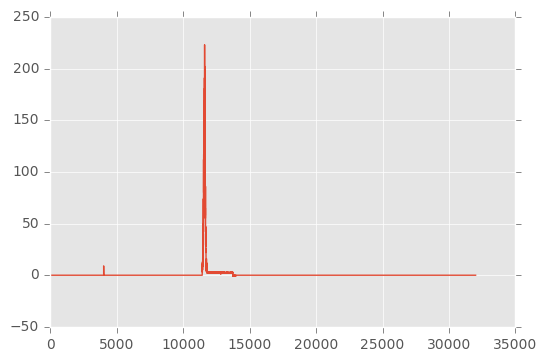

In [255]:
plt.plot(pmtcwf[0,0])
#plt.ylim((-1,5))

In [256]:
a = tbl.read_wf_table(pmttwf,0)
print(a.sum().sum(axis=1).ene_pes)

11098.0


In [257]:
a=pmtzswf.read_where(condition='event==0')
a

array([(0L, 12L, 100.0250015258789, 1.7032424211502075),
       (0L, 12L, 100.05000305175781, 3.5429625511169434),
       (0L, 12L, 100.07499694824219, 3.975395917892456),
       (0L, 12L, 100.0999984741211, 3.565337657928467),
       (0L, 12L, 100.125, 2.6533970832824707),
       (0L, 12L, 100.1500015258789, 2.4998185634613037),
       (0L, 12L, 100.17500305175781, 2.3899614810943604),
       (0L, 12L, 100.19999694824219, 1.9422444105148315),
       (0L, 12L, 285.6000061035156, 2.115849256515503),
       (0L, 12L, 285.625, 1.791792631149292),
       (0L, 12L, 285.79998779296875, 2.551248073577881),
       (0L, 12L, 285.82501220703125, 3.9312310218811035),
       (0L, 12L, 285.8500061035156, 3.5096435546875),
       (0L, 12L, 285.875, 3.565455436706543),
       (0L, 12L, 285.8999938964844, 2.7864503860473633),
       (0L, 12L, 285.92498779296875, 3.1644339561462402),
       (0L, 12L, 285.95001220703125, 3.809248685836792),
       (0L, 12L, 285.9750061035156, 4.391174793243408),
       

11466.5208006


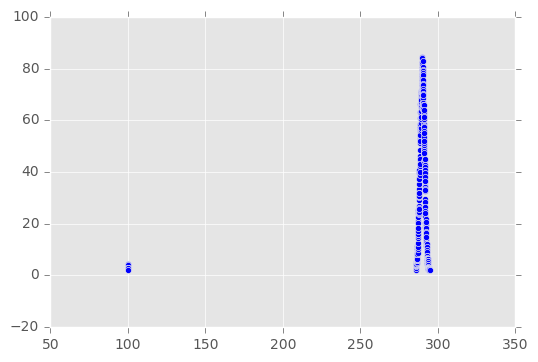

In [27]:
a = tbl.read_wf(pmtzswf,0,12)
print(sum(a[1]))
plt.scatter(a[0],a[1])
#plt.xlim((399,400))
#plt.ylim((-1,5))

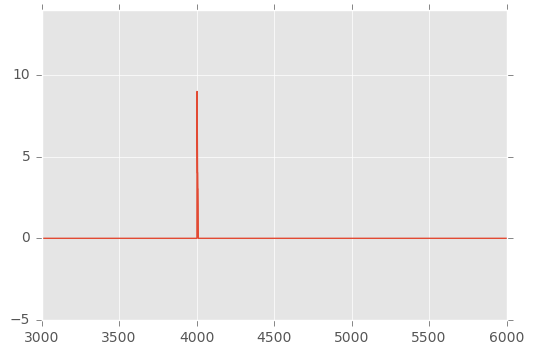

In [28]:
#S1!!
mpl.plts(pmtcwf[0,0],signal_start=3000,signal_end=6000,offset=5)

In [260]:
def sum_evt(wf):
    return np.sum(wf[1])

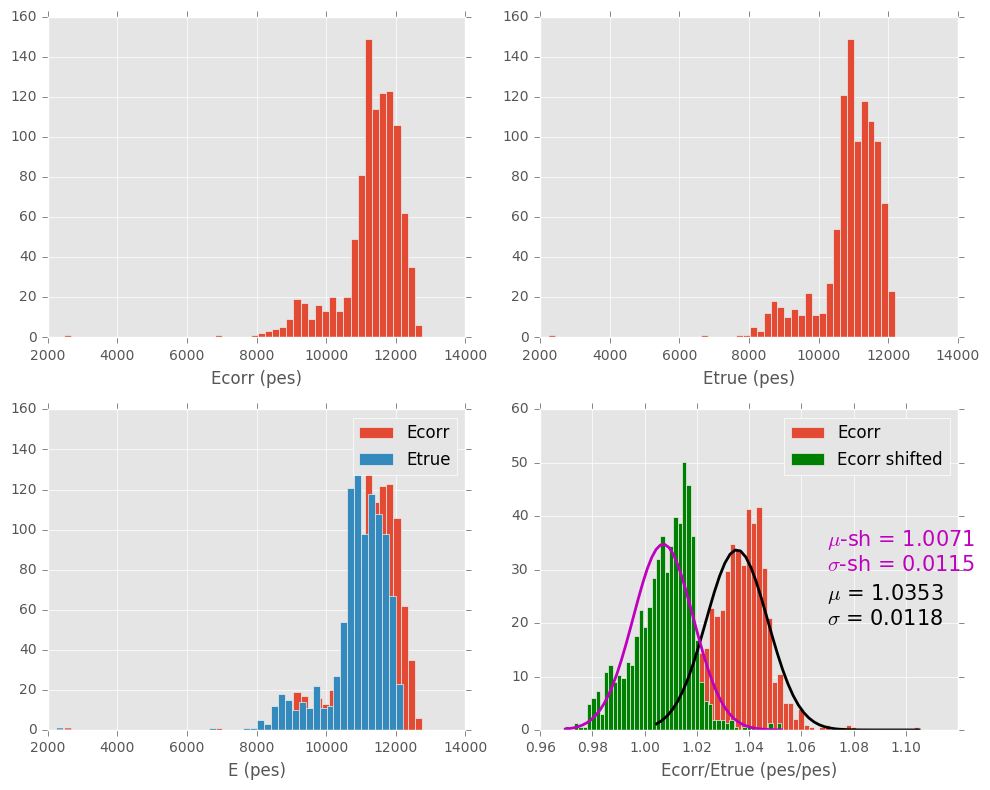

In [26]:
from scipy.stats import norm
import matplotlib.mlab as mlab

nevts = pmtrwf.shape[0]
nbins = 50
Etrue = np.empty(nevts)
Ecorr = np.empty(nevts)

for i in range(nevts):
    Ecorr[i] = np.sum(tbl.read_wf(pmtzswf,i,12)[1])
    Etrue[i] = tbl.read_wf_table(pmttwf,i).sum().sum(axis=1).ene_pes
    '''
    if Ecorr[i] < 1000:
        print(i)
        t,e = tbl.read_wf(pmtzswf,i,12)
        plt.scatter(t,e)
        plt.show()
        raw_input()
    '''

c0,c1 = np.polyfit(Etrue,Ecorr,1)

Eratio = Ecorr/Etrue
EratioCorr = (Ecorr-c1)/Etrue

fig, axes = plt.subplots(2,2)
fig.set_size_inches(10,8)
hcorr  = axes[0,0].hist(Ecorr,nbins)
htrue  = axes[0,1].hist(Etrue,nbins)
hcorr  = axes[1,0].hist(Ecorr,nbins,label='Ecorr')
htrue  = axes[1,0].hist(Etrue,nbins,label='Etrue')
axes[1,0].legend()
hratio = axes[1,1].hist(Eratio,nbins,normed=True,label='Ecorr')
hratioCorr = axes[1,1].hist(EratioCorr,nbins,normed=True,label='Ecorr shifted',color='g')
axes[1,1].legend()

axes[0,0].set_xlabel('Ecorr (pes)')
axes[0,1].set_xlabel('Etrue (pes)')
axes[1,0].set_xlabel('E (pes)')
axes[1,1].set_xlabel('Ecorr/Etrue (pes/pes)')


bins = hratio[1]
mu,sigma = norm.fit(Eratio)
y = mlab.normpdf( bins, mu, sigma)

binsC = hratioCorr[1]
muC,sigmaC = norm.fit(EratioCorr)
yC = mlab.normpdf( binsC, muC, sigmaC)

axes[1,1].text(1.07,20,'$\mu$ = {:.4f}\n$\sigma$ = {:.4f}'.format(mu,sigma),fontsize=15,color='k')
axes[1,1].text(1.07,30,'$\mu$-sh = {:.4f}\n$\sigma$-sh = {:.4f}'.format(muC,sigmaC),fontsize=15,color='m')

ratiof = axes[1,1].plot(bins, y, 'k-', linewidth=2)
ratiofC = axes[1,1].plot(binsC, yC, 'm-', linewidth=2)

plt.tight_layout()


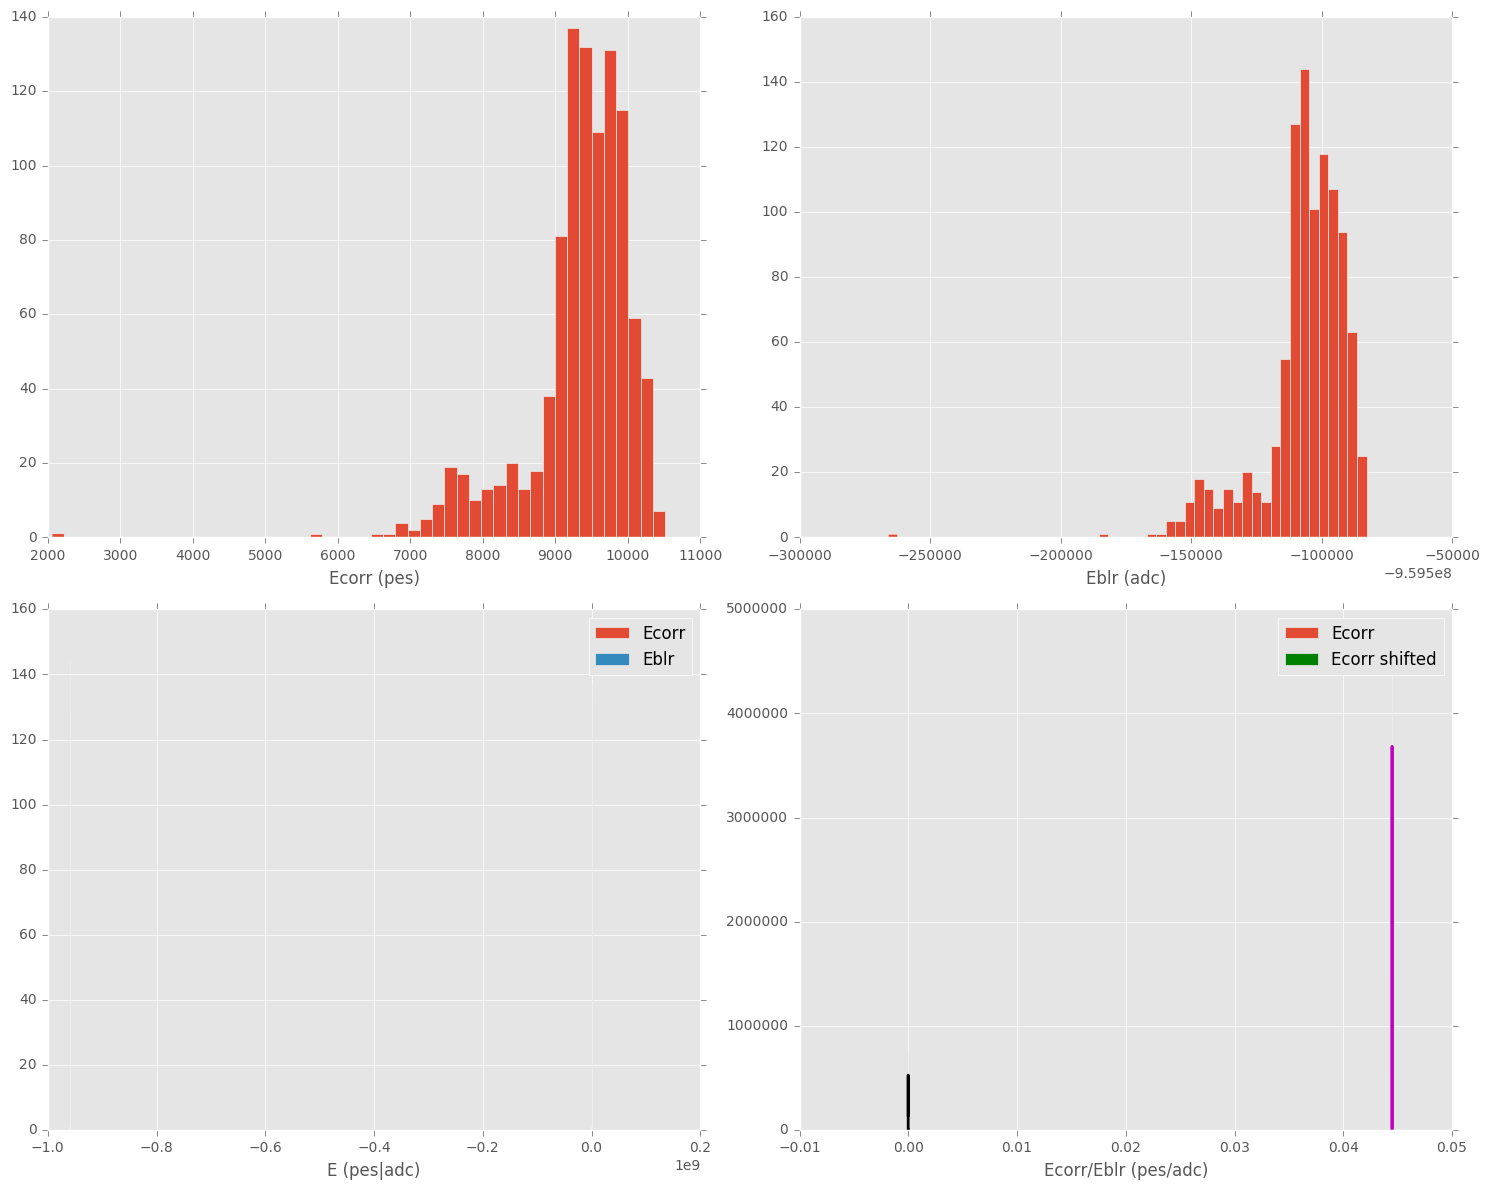

In [280]:
from scipy.stats import norm
import matplotlib.mlab as mlab

nevts = pmtrwf.shape[0]
nbins = 50
Etrue = np.empty(nevts)
Ecorr = np.empty(nevts)

for i in range(nevts):
    Ecorr[i] = np.sum(tbl.read_wf(pmtzswf,i,12)[1])
    Etrue[i] = -pmtblr[i].sum()

c0,c1 = np.polyfit(Etrue,Ecorr,1)

Eratio = Ecorr/Etrue
EratioCorr = (Ecorr-c1)/Etrue

fig, axes = plt.subplots(2,2)
fig.set_size_inches(15,12)
hcorr  = axes[0,0].hist(Ecorr,nbins)
htrue  = axes[0,1].hist(Etrue,nbins)
hcorr  = axes[1,0].hist(Ecorr,nbins,label='Ecorr')
htrue  = axes[1,0].hist(Etrue,nbins,label='Eblr')
axes[1,0].legend()
hratio = axes[1,1].hist(Eratio,nbins,normed=True,label='Ecorr')
hratioCorr = axes[1,1].hist(EratioCorr,nbins,normed=True,label='Ecorr shifted',color='g')
axes[1,1].legend()

axes[0,0].set_xlabel('Ecorr (pes)')
axes[0,1].set_xlabel('Eblr (adc)')
axes[1,0].set_xlabel('E (pes|adc)')
axes[1,1].set_xlabel('Ecorr/Eblr (pes/adc)')


bins = hratio[1]
mu,sigma = norm.fit(Eratio)
y = mlab.normpdf( bins, mu, sigma)

binsC = hratioCorr[1]
muC,sigmaC = norm.fit(EratioCorr)
yC = mlab.normpdf( binsC, muC, sigmaC)

#axes[1,1].text(.88,30,'$\mu$ = {:.4f}\n$\sigma$ = {:.4f}'.format(mu,sigma),fontsize=15,color='k')
#axes[1,1].text(.88,40,'$\mu$-sh = {:.4f}\n$\sigma$-sh = {:.4f}'.format(muC,sigmaC),fontsize=15,color='m')

ratiof = axes[1,1].plot(bins, y, 'k-', linewidth=2)
ratiofC = axes[1,1].plot(binsC, yC, 'm-', linewidth=2)

plt.tight_layout()


(array([ 3.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  3.,
         2.,  1.,  4.,  8.,  7.,  6.,  7.,  4.,  4.,  1.,  7.,  3.,  6.,
         6.,  1.,  3.,  7.,  3.,  1.,  2.,  1.,  0.,  0.,  1.]),
 array([  8477.  ,   8555.02,   8633.04,   8711.06,   8789.08,   8867.1 ,
          8945.12,   9023.14,   9101.16,   9179.18,   9257.2 ,   9335.22,
          9413.24,   9491.26,   9569.28,   9647.3 ,   9725.32,   9803.34,
          9881.36,   9959.38,  10037.4 ,  10115.42,  10193.44,  10271.46,
         10349.48,  10427.5 ,  10505.52,  10583.54,  10661.56,  10739.58,
         10817.6 ,  10895.62,  10973.64,  11051.66,  11129.68,  11207.7 ,
         11285.72,  11363.74,  11441.76,  11519.78,  11597.8 ,  11675.82,
         11753.84,  11831.86,  11909.88,  11987.9 ,  12065.92,  12143.94,
         12221.96,  12299.98,  12378.  ]),
 <a list of 50 Patch objects>)

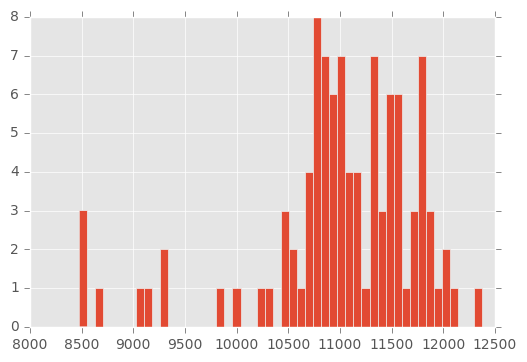

In [166]:
E = []
for i in range(100):
    E.append( tbl.read_wf_table(pmttwf,i).sum().sum(axis=1).ene_pes )

plt.hist(np.array(E),)